### Sequential neural posterior estimation
Sequential neural posterior estimation (SNPE) is an algorithm for fitting posterior
distributions to intractable simulator models. SNPE uses multiple rounds of simulations,
in which posterior estimates from each round are used as proposal distributions for the
subsequent round. This can lead to much higher simulation efficiency compared to a
single round approach. The variant of SNPE used here is often referred to as SNPE-C,
as described by [Greenberg et al. (2019)](https://arxiv.org/abs/1905.07488) and
[Durkan et al. (2020)](https://arxiv.org/abs/2002.03712).

This example uses numpyro, so that we can easily sample a reference/ground truth posterior from the model.

In [1]:
import numpyro.distributions as ndist
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx

from flowjax.train.data_fit import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.distributions import Normal
import flowjax.bijections as bij

The task we consider is to infer the mean of a mixture of two two-dimensional Normal distributions, in which one of the distributions has a much broader variance.
$$\theta \sim N(0,\ I_2)$$
$$x | \theta \sim 0.5 \cdot N(\theta,\ I_2) + 0.5 \cdot N(\theta,\ 0.1^2 \odot I_2)$$

We define this model using numpyro.

In [2]:
def model(observed=None):
    with numpyro.plate("task_dim", 2):
        theta = numpyro.sample("theta", ndist.Normal())
        component = numpyro.sample("c", ndist.Categorical(jnp.array([0.5])), infer={"enumerate": "parallel"})
        scale = jnp.where(component==0, 0.1, 1)
        numpyro.sample("simulations", ndist.Normal(theta, scale), obs=observed)

# Generating an "observation"
key, subkey = jr.split(jr.PRNGKey(1))
observed = Predictive(model, num_samples=1)(subkey)["simulations"][0]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


We use an affine masked autoregressive flow as our proposal/posterior estimator

In [3]:
key, subkey = jr.split(key)
proposal = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros(2), 0.5),
    transformer=bij.Affine(),
    cond_dim=observed.size,
    nn_depth=1,
    flow_layers=4,
    )

For SNPE, training using the standard maximum likelihood loss would lead to biased posterior estimates if the number of rounds is > 1. Instead, we can use [ContrastiveLoss](../api/losses.rst#flowjax.train.losses.ContrastiveLoss). Here we carry out SNPE using 2 rounds of simulations.

In [4]:
def simulate(key, theta):
    predictive = numpyro.infer.Predictive(model, {"theta": theta})
    return predictive(key)["simulations"]

sim_per_round = 500
prior = Normal(jnp.zeros(2))  # Matches prior from the model

loss_fn = ContrastiveLoss(prior, n_contrastive=5)

data = {
    "theta": [],
    "simulations": []
}
losses = []
for r in range(2):
    # Carry out simulations (from prior for round 1, the running proposal otherwise).
    key, theta_key, x_key, train_key = jr.split(key, 4)
    if r==0:
        theta_r = prior.sample(theta_key, (sim_per_round, ))
    else:
        theta_r = eqx.filter_jit(proposal.sample)(
            theta_key, (sim_per_round, ), condition=observed
            )

    simulations_r = simulate(x_key, theta_r)

    data["theta"].append(theta_r)
    data["simulations"].append(simulations_r)

    proposal, losses_r = fit_to_data(
        key=train_key,
        dist=proposal,
        loss_fn=loss_fn,
        x=jnp.concatenate(data["theta"]),  # Note x is package convention for target!
        condition=jnp.concatenate(data["simulations"]),
        learning_rate=5e-4,
        max_epochs=100
    )
    losses.append(losses_r)

# Sample final poseterior estimate
key, theta_key = jr.split(key)
data["theta"].append(
    proposal.sample(theta_key, (1000, ), condition=observed)
)


 33%|███▎      | 33/100 [00:03<00:07,  9.27it/s, train=-4.7783604, val=-5.287825 (Max patience reached)]


We can plot the posterior samples compared to a reference posterior sampled using MCMC.

In [5]:
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=10000)
key, subkey = jr.split(key)
mcmc.run(subkey, observed)
reference_posterior = mcmc.get_samples()["theta"][::10]

sample: 100%|██████████| 11000/11000 [00:03<00:00, 2926.87it/s, 1 steps of size 9.58e-01. acc. prob=0.90]


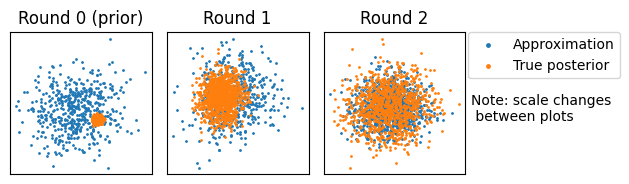

In [7]:
fig, axes = plt.subplots(ncols=len(data["theta"]))

for r, (ax, samps) in enumerate(zip(axes, data["theta"])):
    ax.scatter(samps[:, 0], samps[:, 1], s=1, label="Approximation")
    ax.scatter(reference_posterior[:, 0], reference_posterior[:, 1], s=1, label="True posterior")
    title = "Round 0 (prior)" if r==0 else f"Round {r}"
    ax.set_title(title)
    ax.set_box_aspect(1)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

lgnd = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for handle in lgnd.legend_handles:
    handle.set_sizes([6.0])

plt.tight_layout()
plt.text(1.4, -0.5, "Note: scale changes \n between plots")
plt.show()
